<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/nin2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Network in Network**

# **Section 1. Set up**

In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch import tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### *Dataset and DataLoader*


How to normalize CIFAR-10: [link](https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py).

In [4]:
from torch.utils.data import Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage
from einops import rearrange, reduce


class CIFAR10Dataset(Dataset):
  def __init__(self, root="./data", W=None,train=False, download=True, index=None):    
    cifar10 = CIFAR10(root, train, download=download)
    if index is None:
      self.data, self.targets = cifar10.data, cifar10.targets
    else:
      self.data = cifar10.data[index]
      self.targets = [cifar10.targets[i] for i in index]

    self.normalized_data = self.global_contrast_normalize(self.data)
    self.W = self.zca_matrix(self.normalized_data) if W is None else W
    self.tensors = self.zca_whiten(self.normalized_data)


  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    image, label = self.tensors[idx], self.targets[idx]
    return image, label


  def zca_matrix(self, images):
    n = len(self.targets)
    images = rearrange(images, 'N H W C -> N (H W C)')
    cov = torch.cov(images.T)
    L, V = torch.linalg.eigh(cov)
    L, V = L.real, V.real
    W = V @ torch.diag(L**(-0.5)) @ V.T
    return W


  def zca_whiten(self, images):
    ## Whiten the image
    images = rearrange(images, 'N H W C -> N (H W C)')
    whiten_images =  images @ self.W 
    
    ## Tensorize the image: (dim=(c, h, w) & range=(0, 1))
    whiten_images = rearrange(whiten_images, 'N (H W C) -> N C H W', H=32, W=32)
    return whiten_images


  def global_contrast_normalize(self, images, s=1, llambda=0, epsilon=1e-8):
    images = torch.tensor(images, dtype=torch.float32)
    mean = reduce(images, 'N C H W -> N 1 1 1', 'mean')
    std = (reduce((images-mean)**2, 'N C H W -> N 1 1 1', 'mean') + llambda)**0.5
    denominator = (epsilon<=std) * std + (epsilon>std) * epsilon
    return s*(images-mean)/denominator


[ZCA1](https://stats.stackexchange.com/questions/117427/what-is-the-difference-between-zca-whitening-and-pca-whitening)
[ZCA2](https://towardsdatascience.com/pca-whitening-vs-zca-whitening-a-numpy-2d-visual-518b32033edf#:~:text=ZCA%2Dwhitening%20is%20done%20by,possible%20from%20the%20original%20data.)
[GCN](https://blog.csdn.net/baishuo8/article/details/81943844)

In [5]:
# Generate indices to permute the training data and conduct train-test-split
total_size = 50000
valid_size = total_size // 5
rng = np.random.default_rng(42)
indices = rng.permutation(total_size)

train_dataset = CIFAR10Dataset(train=True, index=indices[:-valid_size])
W = train_dataset.W

valid_dataset = CIFAR10Dataset(train=True, W=W, index=indices[-valid_size:])
test_dataset = CIFAR10Dataset(train=False, W=W)

print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified

Data Size:
* Training set   =>  40000 images
* Validation set =>  10000 images
* Testing set    =>  10000 images

Image Shape (C, H, W):
* Training image: torch.Size([3, 32, 32])
* Testing image:  torch.Size([3, 32, 32])


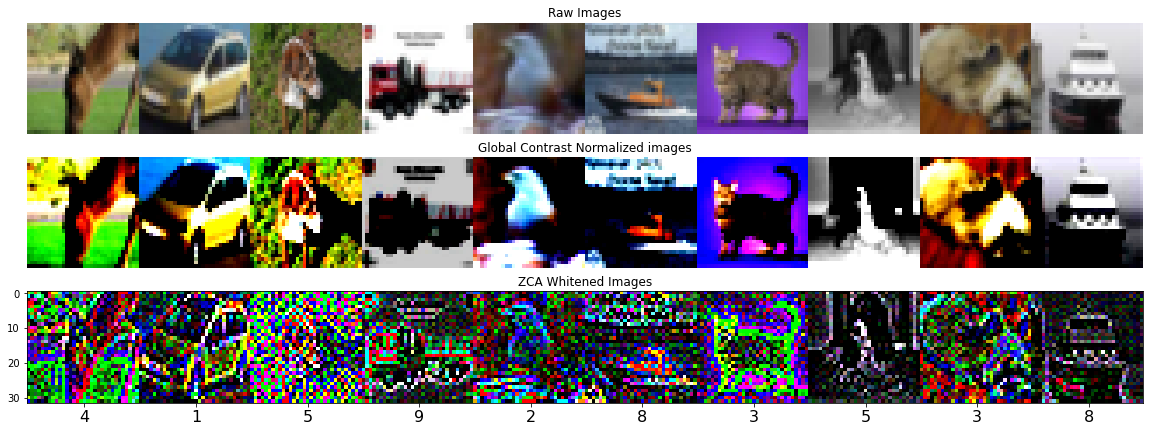


Image shape: (3, 32, 32)


In [6]:
import matplotlib.pyplot as plt

n_view = 10
torch_dstack = lambda images: rearrange(torch.dstack(images), 'C H W -> H W C')

# Sample images
raw_images = np.hstack([train_dataset.data[i] for i in range(n_view)])
normalized_images = np.hstack([train_dataset.normalized_data[i] for i in range(n_view)])
images = torch_dstack([train_dataset[i][0] for i in range(n_view)])
targets = [train_dataset[i][1] for i in range(n_view)]

fig, ax = plt.subplots(3, 1, figsize=(20, 7))
ax[0].imshow(raw_images)
ax[0].set_title("Raw Images")
ax[0].axis('off')

ax[1].imshow(normalized_images)
ax[1].set_title("Global Contrast Normalized images")
ax[1].axis('off')

ax[2].imshow(images)
ax[2].set_title("ZCA Whitened Images")
ax[2].set_xticks(ticks=np.array(range(10))*32+16)
ax[2].set_xticklabels(targets, {'fontsize':16})
plt.show()
plt.close()


image_shape = tuple(train_dataset[0][0].shape)
print("\nImage shape:", image_shape)

In [7]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

### *Network Architecture*

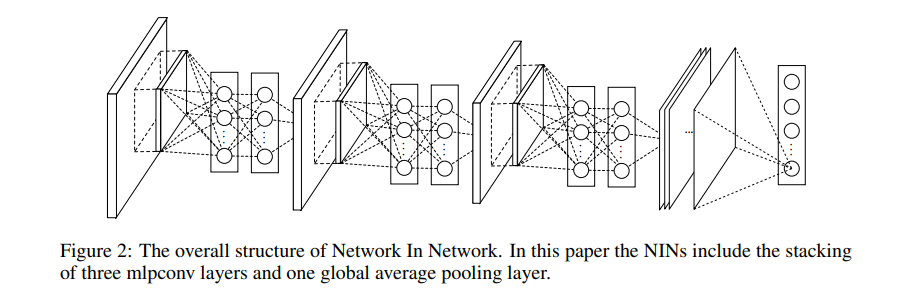

The network architecture is built based on this [prototext](https://gist.github.com/mavenlin/e56253735ef32c3c296d) from the Caffe model zoo. Note one should set `MaxPool2d(ceil_mode=True)` to get the correct dimension.


In [8]:
from torch.nn import (
    Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout, Sequential, Flatten
)


def CCCP(in_channels, out_channels):
  return Conv2d(in_channels, out_channels, kernel_size=1)

def MlpConv(in_channels, hidden_channels, out_channels, kernel_size, stride=1, padding=0):
  return nn.Sequential(
      Conv2d(in_channels, hidden_channels[0], kernel_size, stride, padding),
      ReLU(),
      CCCP(hidden_channels[0], hidden_channels[1]),
      ReLU(),
      CCCP(hidden_channels[1], out_channels),
      ReLU()
  )

class NiN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = Sequential(
        MlpConv(3, (192, 160), 96, kernel_size=5, padding=2),
        MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(96, (192, 192), 192, kernel_size=5, padding=2),
        AvgPool2d(kernel_size=3, stride=2, ceil_mode=True),
        Dropout(p=0.5),

        MlpConv(192, (192, 192), num_classes, kernel_size=3, padding=1),
        AvgPool2d(kernel_size=8, stride=1),
        Flatten()
    )

    # Remember to initialize the weights and biases.
    # Default initialization from pytorch doesn't work well.
    self.net.apply(self.init_weights)

  def forward(self, x):
    return self.net(x)

  @staticmethod
  def init_weights(m):
    if isinstance(m, Conv2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.05)
        torch.nn.init.zeros_(m.bias)

print(NiN())

NiN(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Sequential(
      (0): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (4): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
      (3)

In [9]:
# Check forward path
X = torch.randn(1, *image_shape)
print(f"{'Image shape:':25s} {list(X.shape)}")
for layer in NiN().net:
    X=layer(X)
    print(f"{layer.__class__.__name__+' output shape:':25s} {list(X.shape)}")

Image shape:              [1, 3, 32, 32]
Sequential output shape:  [1, 96, 32, 32]
MaxPool2d output shape:   [1, 96, 16, 16]
Dropout output shape:     [1, 96, 16, 16]
Sequential output shape:  [1, 192, 16, 16]
AvgPool2d output shape:   [1, 192, 8, 8]
Dropout output shape:     [1, 192, 8, 8]
Sequential output shape:  [1, 10, 8, 8]
AvgPool2d output shape:   [1, 10, 1, 1]
Flatten output shape:     [1, 10]


### *HyperModule*

In [10]:
import sklearn.metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class HyperModule():
    def __init__(self, model, criterion, optimizer, scheduler=None, load_path=None):
        if load_path is None:
            self.model, self.criterion, self.optimizer = model, criterion, optimizer
            self.scheduler = scheduler
            self.epoch_trained = 0
            self.train_loss = []
            self.valid_acc = []
            self.test_acc = None
        else:
            self.load(load_path)


    def train(self, train_dataloader, valid_dataloader, save_path=None, num_epochs=1):
        device = torch.device('cuda')
        self.model.to(device)
        best_acc = 0 if len(self.valid_acc)==0 else max(self.valid_acc) 
        start_epoch = self.epoch_trained

        for epoch in range(num_epochs):
            self.model.train()
            self.batch_loss, self.batch_acc = [], []
            self.epoch_trained += 1

            train_progress = tqdm(train_dataloader, position=0, leave=True)  ## Train
            for images, targets in train_progress:
                images, targets = images.to(device), targets.to(device)
                self.update_(images, targets)
                self.update_prog_(train_progress, start_epoch+num_epochs)
           
            self.update_schd_()  ## Update scheduler

            self.batch_acc = self.validate(valid_dataloader) ## Validate
            self.update_hist_()
            print(f"Train Loss: {np.mean(self.batch_loss):.3f}, Valid Acc:{np.mean(self.batch_acc):.3f}")
            
            if np.mean(self.batch_acc) > best_acc:  ## Save the best model (if any)
                best_acc = np.mean(self.batch_acc)
                self.save(save_path)

        self.batch_loss, self.batch_acc = [], []
        self.test_acc = None
        

    def validate(self, dataloader):
        device = torch.device('cuda')
        self.model.eval()
        batch_acc = []
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(device), targets.to(device)
                preds = self.model(images)
                pred_labels = torch.argmax(preds, dim=1)
                batch_acc.append((pred_labels == targets).type(torch.float32).mean().item())
        return batch_acc


    def test(self, dataloader, load_path=None, confusion_matrix=True, class_names=None):
        device = torch.device('cuda')
        np_pred_labels, np_targets = [], [] 
        if load_path is not None:
            self.load(load_path)
        self.model.to(device)
        self.model.eval()

        # Obtain predictions and ground truths
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(device), targets.to(device)
                pred_labels, targets = self.get_prediction_(images, targets)
                np_pred_labels.append(pred_labels)
                np_targets.append(targets)

        np_pred_labels = np.concatenate(np_pred_labels)
        np_targets = np.concatenate(np_targets)

        if confusion_matrix:
            conf_mat = sklearn.metrics.confusion_matrix(np_targets, np_pred_labels)
            conf_df = self.generate_confusion_df_(conf_mat, class_names)
            self.plot_confusion_matrix_(conf_df)
            self.print_class_acc_(conf_df)
        
        ## print total accuracy
        self.test_acc = np.mean(np_targets == np_pred_labels)
        print("\nTotal Acc:", np.mean(np_targets == np_pred_labels))

                
    def load(self, path):
        device = torch.device('cuda')
        state_dict = torch.load(path)
        
        self.model.load_state_dict(state_dict["model"])
        self.model.to(device)
        
        self.optimizer.load_state_dict(state_dict["optimizer"])
        self.scheduler.load_state_dict(state_dict["scheduler"])
        self.test_acc = state_dict["test_acc"]

        n_train_loss = len(state_dict["train_loss"])
        n_valid_acc = len(state_dict["valid_acc"])
        epoch_trained = state_dict["epoch_trained"]
        n = min(epoch_trained, n_train_loss, n_valid_acc)

        self.epoch_trained = n
        self.train_loss = state_dict["train_loss"][:n]
        self.valid_acc = state_dict["valid_acc"][:n]
        print("State dict sucessfully loaded.")


    def save(self, path):
        state_dict = {}
        state_dict["model"] = self.model.state_dict()
        state_dict["optimizer"] = self.optimizer.state_dict()
        state_dict["scheduler"] = self.scheduler.state_dict()
        state_dict["epoch_trained"] = self.epoch_trained
        state_dict["train_loss"] = self.train_loss
        state_dict["valid_acc"] = self.valid_acc
        state_dict["test_acc"] = self.test_acc
        torch.save(state_dict, path)
        print("State dict saved.")
    

    def get_state_dict(self):
        state_dict = {}
        state_dict["model"] = self.model.state_dict()
        state_dict["optimizer"] = self.optimizer.state_dict()
        state_dict["scheduler"] = self.scheduler.state_dict()
        state_dict["epoch_trained"] = self.epoch_trained
        state_dict["train_loss"] = self.train_loss
        state_dict["valid_acc"] = self.valid_acc
        state_dict["test_acc"] = self.test_acc
        return state_dict

    #--------------------------------------------------------------------------#

    ### Auxilary functions in test()
     
    def get_prediction_(self, images, targets):
        preds = self.model(images)
        pred_labels = torch.argmax(preds, dim=1)
        pred_labels = pred_labels.view(-1).detach().cpu().numpy()
        targets = targets.view(-1).detach().cpu().numpy()
        return pred_labels, targets

    def generate_confusion_df_(self, conf_mat, class_names):
        if class_names is not None:
            conf_df = pd.DataFrame(conf_mat, class_names, class_names)
        else:
            conf_df = pd.DataFrame(conf_mat)
        return conf_df
        
    def plot_confusion_matrix_(self, conf_df):
        plt.figure(figsize = (12,8))
        sns.heatmap(conf_df, annot=True, fmt="d", cmap='Blues')
        plt.xlabel("prediction")
        plt.ylabel("label (ground truth)")
        plt.show()

    def print_class_acc_(self, conf_df):
        for i in range(len(conf_df)):
            total = np.sum(conf_df.iloc[i, :])
            correct = conf_df.iloc[i, i]
            print(f"Acc of {conf_df.columns[i]}: {correct/total:.4f}")

    
    ### Auxilary functions in train()
    
    def update_(self, images, targets):
        preds = self.model(images)
        loss = self.criterion(preds, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.batch_loss.append(loss.detach().item())

    def update_prog_(self, progress, num_epochs):
        loss = self.batch_loss[-1]
        epoch = self.epoch_trained
        progress.set_description(f'Epoch [{epoch}/{num_epochs}]')
        progress.set_postfix({'loss': loss})

    def update_schd_(self):
        if self.scheduler is not None:
            self.scheduler.step()

    def update_hist_(self):
        # print("Train loss updated:", np.mean(self.batch_loss))
        self.train_loss.append(np.mean(self.batch_loss))
        # print("Valid acc updated:", np.mean(self.batch_acc))
        self.valid_acc.append(np.mean(self.batch_acc))

# **Section 2. Start Training**

### *Optimization Configuration and First Training Stage*

In [15]:
BASE_LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
STEP_SIZE = 1e5
GAMMA = 0.1
NUM_EPOCHS = 230
PATH = "/content/gdrive/MyDrive/Colab Checkpoints/state_dict.ckpt"

In [16]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

nin = NiN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nin.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, STEP_SIZE, GAMMA)

hm = HyperModule(
    model = nin,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler
)

hm.train(train_dataloader, valid_dataloader, PATH, NUM_EPOCHS)

Epoch [1/230]: 100%|██████████| 313/313 [00:19<00:00, 16.30it/s, loss=2.25]


Train Loss: 2.243, Valid Acc:0.188
State dict saved.


Epoch [2/230]: 100%|██████████| 313/313 [00:19<00:00, 16.34it/s, loss=2.06]


Train Loss: 2.103, Valid Acc:0.270
State dict saved.


Epoch [3/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=1.54]


Train Loss: 1.770, Valid Acc:0.339
State dict saved.


Epoch [4/230]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=1.34]


Train Loss: 1.523, Valid Acc:0.456
State dict saved.


Epoch [5/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=1.13]


Train Loss: 1.302, Valid Acc:0.549
State dict saved.


Epoch [6/230]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=1.16]


Train Loss: 1.182, Valid Acc:0.592
State dict saved.


Epoch [7/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.901]


Train Loss: 1.053, Valid Acc:0.618
State dict saved.


Epoch [8/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=1.07]


Train Loss: 0.958, Valid Acc:0.676
State dict saved.


Epoch [9/230]: 100%|██████████| 313/313 [00:18<00:00, 16.47it/s, loss=0.676]


Train Loss: 0.884, Valid Acc:0.714
State dict saved.


Epoch [10/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.819]


Train Loss: 0.804, Valid Acc:0.683


Epoch [11/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.862]


Train Loss: 0.760, Valid Acc:0.741
State dict saved.


Epoch [12/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.871]


Train Loss: 0.715, Valid Acc:0.756
State dict saved.


Epoch [13/230]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.773]


Train Loss: 0.659, Valid Acc:0.728


Epoch [14/230]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.748]


Train Loss: 0.637, Valid Acc:0.741


Epoch [15/230]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.625]


Train Loss: 0.591, Valid Acc:0.775
State dict saved.


Epoch [16/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.574]


Train Loss: 0.567, Valid Acc:0.785
State dict saved.


Epoch [17/230]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.402]


Train Loss: 0.534, Valid Acc:0.766


Epoch [18/230]: 100%|██████████| 313/313 [00:19<00:00, 16.46it/s, loss=0.482]


Train Loss: 0.516, Valid Acc:0.782


Epoch [19/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.566]


Train Loss: 0.485, Valid Acc:0.771


Epoch [20/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.411]


Train Loss: 0.461, Valid Acc:0.791
State dict saved.


Epoch [21/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.55]


Train Loss: 0.454, Valid Acc:0.799
State dict saved.


Epoch [22/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.479]


Train Loss: 0.434, Valid Acc:0.786


Epoch [23/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.417]


Train Loss: 0.418, Valid Acc:0.798


Epoch [24/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.548]


Train Loss: 0.417, Valid Acc:0.799


Epoch [25/230]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.436]


Train Loss: 0.389, Valid Acc:0.813
State dict saved.


Epoch [26/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.408]


Train Loss: 0.385, Valid Acc:0.814
State dict saved.


Epoch [27/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.499]


Train Loss: 0.373, Valid Acc:0.812


Epoch [28/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.2]


Train Loss: 0.359, Valid Acc:0.795


Epoch [29/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.619]


Train Loss: 0.359, Valid Acc:0.818
State dict saved.


Epoch [30/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.426]


Train Loss: 0.355, Valid Acc:0.819
State dict saved.


Epoch [31/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.415]


Train Loss: 0.338, Valid Acc:0.796


Epoch [32/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.393]


Train Loss: 0.341, Valid Acc:0.802


Epoch [33/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.25]


Train Loss: 0.316, Valid Acc:0.819
State dict saved.


Epoch [34/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.294]


Train Loss: 0.316, Valid Acc:0.819


Epoch [35/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.2]


Train Loss: 0.308, Valid Acc:0.813


Epoch [36/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.209]


Train Loss: 0.301, Valid Acc:0.820
State dict saved.


Epoch [37/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.713]


Train Loss: 0.293, Valid Acc:0.815


Epoch [38/230]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.168]


Train Loss: 0.292, Valid Acc:0.794


Epoch [39/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.297]


Train Loss: 0.286, Valid Acc:0.826
State dict saved.


Epoch [40/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.237]


Train Loss: 0.287, Valid Acc:0.822


Epoch [41/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.406]


Train Loss: 0.293, Valid Acc:0.827
State dict saved.


Epoch [42/230]: 100%|██████████| 313/313 [00:18<00:00, 16.61it/s, loss=0.155]


Train Loss: 0.268, Valid Acc:0.820


Epoch [43/230]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.262]


Train Loss: 0.270, Valid Acc:0.827


Epoch [44/230]: 100%|██████████| 313/313 [00:18<00:00, 16.62it/s, loss=0.415]


Train Loss: 0.267, Valid Acc:0.818


Epoch [45/230]: 100%|██████████| 313/313 [00:18<00:00, 16.63it/s, loss=0.342]


Train Loss: 0.261, Valid Acc:0.822


Epoch [46/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.217]


Train Loss: 0.254, Valid Acc:0.829
State dict saved.


Epoch [47/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.211]


Train Loss: 0.254, Valid Acc:0.829


Epoch [48/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.267]


Train Loss: 0.256, Valid Acc:0.825


Epoch [49/230]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.138]


Train Loss: 0.254, Valid Acc:0.833
State dict saved.


Epoch [50/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.304]


Train Loss: 0.241, Valid Acc:0.819


Epoch [51/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.332]


Train Loss: 0.240, Valid Acc:0.830


Epoch [52/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.388]


Train Loss: 0.243, Valid Acc:0.833
State dict saved.


Epoch [53/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.176]


Train Loss: 0.242, Valid Acc:0.824


Epoch [54/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.205]


Train Loss: 0.242, Valid Acc:0.830


Epoch [55/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.273]


Train Loss: 0.237, Valid Acc:0.827


Epoch [56/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.192]


Train Loss: 0.231, Valid Acc:0.812


Epoch [57/230]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.288]


Train Loss: 0.227, Valid Acc:0.834
State dict saved.


Epoch [58/230]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.21]


Train Loss: 0.237, Valid Acc:0.823


Epoch [59/230]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.299]


Train Loss: 0.227, Valid Acc:0.815


Epoch [60/230]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.174]


Train Loss: 0.235, Valid Acc:0.822


Epoch [61/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.326]


Train Loss: 0.219, Valid Acc:0.827


Epoch [62/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.191]


Train Loss: 0.239, Valid Acc:0.841
State dict saved.


Epoch [63/230]: 100%|██████████| 313/313 [00:18<00:00, 16.60it/s, loss=0.293]


Train Loss: 0.219, Valid Acc:0.817


Epoch [64/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.199]


Train Loss: 0.223, Valid Acc:0.830


Epoch [65/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.266]


Train Loss: 0.213, Valid Acc:0.846
State dict saved.


Epoch [66/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.311]


Train Loss: 0.217, Valid Acc:0.845


Epoch [67/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.203]


Train Loss: 0.217, Valid Acc:0.828


Epoch [68/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.378]


Train Loss: 0.211, Valid Acc:0.832


Epoch [69/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.17]


Train Loss: 0.213, Valid Acc:0.837


Epoch [70/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.29]


Train Loss: 0.234, Valid Acc:0.821


Epoch [71/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.264]


Train Loss: 0.213, Valid Acc:0.838


Epoch [72/230]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.227]


Train Loss: 0.206, Valid Acc:0.839


Epoch [73/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.207]


Train Loss: 0.210, Valid Acc:0.829


Epoch [74/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.259]


Train Loss: 0.210, Valid Acc:0.834


Epoch [75/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.247]


Train Loss: 0.195, Valid Acc:0.838


Epoch [76/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.213]


Train Loss: 0.207, Valid Acc:0.834


Epoch [77/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.13]


Train Loss: 0.203, Valid Acc:0.839


Epoch [78/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.115]


Train Loss: 0.202, Valid Acc:0.841


Epoch [79/230]: 100%|██████████| 313/313 [00:18<00:00, 16.60it/s, loss=0.141]


Train Loss: 0.200, Valid Acc:0.830


Epoch [80/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.129]


Train Loss: 0.198, Valid Acc:0.832


Epoch [81/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.236]


Train Loss: 0.199, Valid Acc:0.829


Epoch [82/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.232]


Train Loss: 0.193, Valid Acc:0.843


Epoch [83/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.229]


Train Loss: 0.205, Valid Acc:0.828


Epoch [84/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.106]


Train Loss: 0.184, Valid Acc:0.844


Epoch [85/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.405]


Train Loss: 0.195, Valid Acc:0.828


Epoch [86/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.218]


Train Loss: 0.197, Valid Acc:0.827


Epoch [87/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.242]


Train Loss: 0.193, Valid Acc:0.836


Epoch [88/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.275]


Train Loss: 0.201, Valid Acc:0.842


Epoch [89/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.139]


Train Loss: 0.189, Valid Acc:0.836


Epoch [90/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.127]


Train Loss: 0.190, Valid Acc:0.840


Epoch [91/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.0579]


Train Loss: 0.201, Valid Acc:0.836


Epoch [92/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.23]


Train Loss: 0.192, Valid Acc:0.837


Epoch [93/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.233]


Train Loss: 0.187, Valid Acc:0.838


Epoch [94/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.129]


Train Loss: 0.187, Valid Acc:0.845


Epoch [95/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.118]


Train Loss: 0.191, Valid Acc:0.840


Epoch [96/230]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.316]


Train Loss: 0.188, Valid Acc:0.827


Epoch [97/230]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.119]


Train Loss: 0.188, Valid Acc:0.843


Epoch [98/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.197]


Train Loss: 0.182, Valid Acc:0.834


Epoch [99/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.333]


Train Loss: 0.199, Valid Acc:0.842


Epoch [100/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.283]


Train Loss: 0.187, Valid Acc:0.834


Epoch [101/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.497]


Train Loss: 0.185, Valid Acc:0.831


Epoch [102/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.253]


Train Loss: 0.189, Valid Acc:0.837


Epoch [103/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.166]


Train Loss: 0.192, Valid Acc:0.840


Epoch [104/230]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.305]


Train Loss: 0.184, Valid Acc:0.823


Epoch [105/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.195]


Train Loss: 0.178, Valid Acc:0.825


Epoch [106/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.423]


Train Loss: 0.174, Valid Acc:0.839


Epoch [107/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.255]


Train Loss: 0.174, Valid Acc:0.838


Epoch [108/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.186]


Train Loss: 0.181, Valid Acc:0.838


Epoch [109/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.22]


Train Loss: 0.180, Valid Acc:0.845


Epoch [110/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.154]


Train Loss: 0.175, Valid Acc:0.847
State dict saved.


Epoch [111/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.196]


Train Loss: 0.186, Valid Acc:0.832


Epoch [112/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.122]


Train Loss: 0.170, Valid Acc:0.838


Epoch [113/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.19]


Train Loss: 0.179, Valid Acc:0.842


Epoch [114/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.429]


Train Loss: 0.185, Valid Acc:0.840


Epoch [115/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.201]


Train Loss: 0.186, Valid Acc:0.843


Epoch [116/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.116]


Train Loss: 0.185, Valid Acc:0.834


Epoch [117/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.316]


Train Loss: 0.181, Valid Acc:0.854
State dict saved.


Epoch [118/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.18]


Train Loss: 0.175, Valid Acc:0.834


Epoch [119/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0507]


Train Loss: 0.169, Valid Acc:0.853


Epoch [120/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.189]


Train Loss: 0.175, Valid Acc:0.850


Epoch [121/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.123]


Train Loss: 0.168, Valid Acc:0.837


Epoch [122/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.235]


Train Loss: 0.173, Valid Acc:0.842


Epoch [123/230]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.203]


Train Loss: 0.180, Valid Acc:0.840


Epoch [124/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0959]


Train Loss: 0.168, Valid Acc:0.841


Epoch [125/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.136]


Train Loss: 0.173, Valid Acc:0.852


Epoch [126/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.137]


Train Loss: 0.167, Valid Acc:0.842


Epoch [127/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.172]


Train Loss: 0.166, Valid Acc:0.838


Epoch [128/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.153]


Train Loss: 0.171, Valid Acc:0.839


Epoch [129/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.243]


Train Loss: 0.179, Valid Acc:0.847


Epoch [130/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.248]


Train Loss: 0.183, Valid Acc:0.849


Epoch [131/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.443]


Train Loss: 0.169, Valid Acc:0.845


Epoch [132/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.262]


Train Loss: 0.163, Valid Acc:0.841


Epoch [133/230]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.107]


Train Loss: 0.170, Valid Acc:0.837


Epoch [134/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.194]


Train Loss: 0.159, Valid Acc:0.847


Epoch [135/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.185]


Train Loss: 0.168, Valid Acc:0.837


Epoch [136/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.124]


Train Loss: 0.177, Valid Acc:0.837


Epoch [137/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.222]


Train Loss: 0.171, Valid Acc:0.840


Epoch [138/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.153]


Train Loss: 0.180, Valid Acc:0.824


Epoch [139/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.253]


Train Loss: 0.173, Valid Acc:0.838


Epoch [140/230]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.215]


Train Loss: 0.162, Valid Acc:0.836


Epoch [141/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.17]


Train Loss: 0.170, Valid Acc:0.850


Epoch [142/230]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.156]


Train Loss: 0.170, Valid Acc:0.841


Epoch [143/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.134]


Train Loss: 0.162, Valid Acc:0.838


Epoch [144/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.22]


Train Loss: 0.157, Valid Acc:0.850


Epoch [145/230]: 100%|██████████| 313/313 [00:18<00:00, 16.61it/s, loss=0.246]


Train Loss: 0.163, Valid Acc:0.839


Epoch [146/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.203]


Train Loss: 0.170, Valid Acc:0.849


Epoch [147/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.276]


Train Loss: 0.162, Valid Acc:0.845


Epoch [148/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.0646]


Train Loss: 0.165, Valid Acc:0.828


Epoch [149/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.227]


Train Loss: 0.170, Valid Acc:0.843


Epoch [150/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.131]


Train Loss: 0.169, Valid Acc:0.856
State dict saved.


Epoch [151/230]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.155]


Train Loss: 0.154, Valid Acc:0.841


Epoch [152/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.104]


Train Loss: 0.172, Valid Acc:0.848


Epoch [153/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.136]


Train Loss: 0.171, Valid Acc:0.846


Epoch [154/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.0917]


Train Loss: 0.162, Valid Acc:0.833


Epoch [155/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.246]


Train Loss: 0.153, Valid Acc:0.854


Epoch [156/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.216]


Train Loss: 0.169, Valid Acc:0.832


Epoch [157/230]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.342]


Train Loss: 0.164, Valid Acc:0.841


Epoch [158/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.135]


Train Loss: 0.166, Valid Acc:0.849


Epoch [159/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.155]


Train Loss: 0.168, Valid Acc:0.840


Epoch [160/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.233]


Train Loss: 0.163, Valid Acc:0.848


Epoch [161/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.127]


Train Loss: 0.163, Valid Acc:0.842


Epoch [162/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.134]


Train Loss: 0.164, Valid Acc:0.843


Epoch [163/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.159]


Train Loss: 0.156, Valid Acc:0.844


Epoch [164/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.184]


Train Loss: 0.156, Valid Acc:0.847


Epoch [165/230]: 100%|██████████| 313/313 [00:18<00:00, 16.61it/s, loss=0.109]


Train Loss: 0.169, Valid Acc:0.854


Epoch [166/230]: 100%|██████████| 313/313 [00:18<00:00, 16.62it/s, loss=0.235]


Train Loss: 0.160, Valid Acc:0.843


Epoch [167/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.0992]


Train Loss: 0.168, Valid Acc:0.852


Epoch [168/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.281]


Train Loss: 0.151, Valid Acc:0.840


Epoch [169/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.253]


Train Loss: 0.171, Valid Acc:0.839


Epoch [170/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.135]


Train Loss: 0.160, Valid Acc:0.846


Epoch [171/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.181]


Train Loss: 0.160, Valid Acc:0.842


Epoch [172/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.112]


Train Loss: 0.152, Valid Acc:0.847


Epoch [173/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.174]


Train Loss: 0.159, Valid Acc:0.840


Epoch [174/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.135]


Train Loss: 0.159, Valid Acc:0.830


Epoch [175/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.13]


Train Loss: 0.159, Valid Acc:0.856
State dict saved.


Epoch [176/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.251]


Train Loss: 0.153, Valid Acc:0.843


Epoch [177/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.28]


Train Loss: 0.158, Valid Acc:0.849


Epoch [178/230]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.069]


Train Loss: 0.144, Valid Acc:0.841


Epoch [179/230]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.14]


Train Loss: 0.167, Valid Acc:0.820


Epoch [180/230]: 100%|██████████| 313/313 [00:19<00:00, 16.46it/s, loss=0.246]


Train Loss: 0.151, Valid Acc:0.852


Epoch [181/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0897]


Train Loss: 0.154, Valid Acc:0.841


Epoch [182/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.128]


Train Loss: 0.157, Valid Acc:0.845


Epoch [183/230]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.151]


Train Loss: 0.160, Valid Acc:0.841


Epoch [184/230]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.274]


Train Loss: 0.167, Valid Acc:0.844


Epoch [185/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.188]


Train Loss: 0.165, Valid Acc:0.833


Epoch [186/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.0952]


Train Loss: 0.163, Valid Acc:0.825


Epoch [187/230]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.0383]


Train Loss: 0.157, Valid Acc:0.855


Epoch [188/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0944]


Train Loss: 0.148, Valid Acc:0.848


Epoch [189/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.25]


Train Loss: 0.154, Valid Acc:0.854


Epoch [190/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.283]


Train Loss: 0.156, Valid Acc:0.844


Epoch [191/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.106]


Train Loss: 0.152, Valid Acc:0.855


Epoch [192/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.0798]


Train Loss: 0.151, Valid Acc:0.853


Epoch [193/230]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.175]


Train Loss: 0.152, Valid Acc:0.837


Epoch [194/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.322]


Train Loss: 0.153, Valid Acc:0.848


Epoch [195/230]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.201]


Train Loss: 0.157, Valid Acc:0.848


Epoch [196/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.153]


Train Loss: 0.152, Valid Acc:0.844


Epoch [197/230]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.221]


Train Loss: 0.150, Valid Acc:0.841


Epoch [198/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.24]


Train Loss: 0.155, Valid Acc:0.844


Epoch [199/230]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.0418]


Train Loss: 0.152, Valid Acc:0.853


Epoch [200/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.331]


Train Loss: 0.146, Valid Acc:0.854


Epoch [201/230]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.169]


Train Loss: 0.146, Valid Acc:0.848


Epoch [202/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.184]


Train Loss: 0.145, Valid Acc:0.851


Epoch [203/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.203]


Train Loss: 0.159, Valid Acc:0.843


Epoch [204/230]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.12]


Train Loss: 0.148, Valid Acc:0.853


Epoch [205/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.307]


Train Loss: 0.155, Valid Acc:0.850


Epoch [206/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.157]


Train Loss: 0.160, Valid Acc:0.841


Epoch [207/230]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.223]


Train Loss: 0.149, Valid Acc:0.852


Epoch [208/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.162]


Train Loss: 0.156, Valid Acc:0.845


Epoch [209/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.223]


Train Loss: 0.154, Valid Acc:0.833


Epoch [210/230]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.145]


Train Loss: 0.155, Valid Acc:0.854


Epoch [211/230]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.15]


Train Loss: 0.152, Valid Acc:0.857
State dict saved.


Epoch [212/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.176]


Train Loss: 0.158, Valid Acc:0.851


Epoch [213/230]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.351]


Train Loss: 0.138, Valid Acc:0.847


Epoch [214/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.2]


Train Loss: 0.165, Valid Acc:0.848


Epoch [215/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.125]


Train Loss: 0.149, Valid Acc:0.851


Epoch [216/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.234]


Train Loss: 0.150, Valid Acc:0.849


Epoch [217/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.208]


Train Loss: 0.149, Valid Acc:0.857
State dict saved.


Epoch [218/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.206]


Train Loss: 0.152, Valid Acc:0.842


Epoch [219/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.15]


Train Loss: 0.151, Valid Acc:0.839


Epoch [220/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.171]


Train Loss: 0.152, Valid Acc:0.851


Epoch [221/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.0472]


Train Loss: 0.152, Valid Acc:0.853


Epoch [222/230]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.107]


Train Loss: 0.145, Valid Acc:0.847


Epoch [223/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.137]


Train Loss: 0.151, Valid Acc:0.851


Epoch [224/230]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.17]


Train Loss: 0.152, Valid Acc:0.863
State dict saved.


Epoch [225/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.0723]


Train Loss: 0.149, Valid Acc:0.842


Epoch [226/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.138]


Train Loss: 0.150, Valid Acc:0.824


Epoch [227/230]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.119]


Train Loss: 0.154, Valid Acc:0.846


Epoch [228/230]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.168]


Train Loss: 0.148, Valid Acc:0.840


Epoch [229/230]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.0505]


Train Loss: 0.142, Valid Acc:0.850


Epoch [230/230]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0681]


Train Loss: 0.148, Valid Acc:0.845


State dict sucessfully loaded.


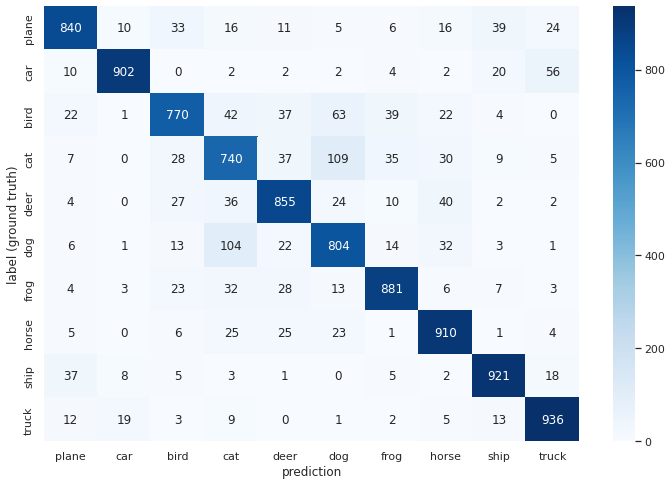

Acc of plane: 0.8400
Acc of car: 0.9020
Acc of bird: 0.7700
Acc of cat: 0.7400
Acc of deer: 0.8550
Acc of dog: 0.8040
Acc of frog: 0.8810
Acc of horse: 0.9100
Acc of ship: 0.9210
Acc of truck: 0.9360

Total Acc: 0.8559


In [17]:
hm.test(test_dataloader, load_path=PATH, class_names=class_names)

In [18]:
BASE_LR = 0.01
MOMENTUM = 0.5
WEIGHT_DECAY = 1e-4
STEP_SIZE = 1e4
GAMMA = 0.1
NUM_EPOCHS = 100
PATH = "/content/gdrive/MyDrive/Colab Checkpoints/state_dict.ckpt"

In [20]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
nin = NiN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nin.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, STEP_SIZE, GAMMA)

hm = HyperModule(
    model = nin,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler
)
hm.load(PATH)
hm.optimizer = torch.optim.SGD(hm.model.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
hm.scheduler = torch.optim.lr_scheduler.StepLR(hm.optimizer, STEP_SIZE, GAMMA)
hm.train(train_dataloader, valid_dataloader, PATH, NUM_EPOCHS)

State dict sucessfully loaded.


Epoch [225/324]: 100%|██████████| 313/313 [00:18<00:00, 17.26it/s, loss=0.0566]


Train Loss: 0.076, Valid Acc:0.872
State dict saved.


Epoch [226/324]: 100%|██████████| 313/313 [00:18<00:00, 17.02it/s, loss=0.0195]


Train Loss: 0.059, Valid Acc:0.874
State dict saved.


Epoch [227/324]: 100%|██████████| 313/313 [00:18<00:00, 16.91it/s, loss=0.0125]


Train Loss: 0.050, Valid Acc:0.875
State dict saved.


Epoch [228/324]: 100%|██████████| 313/313 [00:18<00:00, 16.81it/s, loss=0.026]


Train Loss: 0.046, Valid Acc:0.876
State dict saved.


Epoch [229/324]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.0338]


Train Loss: 0.042, Valid Acc:0.877
State dict saved.


Epoch [230/324]: 100%|██████████| 313/313 [00:19<00:00, 16.45it/s, loss=0.0102]


Train Loss: 0.041, Valid Acc:0.879
State dict saved.


Epoch [231/324]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.0199]


Train Loss: 0.039, Valid Acc:0.879


Epoch [232/324]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.011]


Train Loss: 0.037, Valid Acc:0.878


Epoch [233/324]: 100%|██████████| 313/313 [00:19<00:00, 16.44it/s, loss=0.104]


Train Loss: 0.034, Valid Acc:0.878


Epoch [234/324]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.0307]


Train Loss: 0.033, Valid Acc:0.879


Epoch [235/324]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.0586]


Train Loss: 0.032, Valid Acc:0.879
State dict saved.


Epoch [236/324]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0119]


Train Loss: 0.029, Valid Acc:0.880
State dict saved.


Epoch [237/324]: 100%|██████████| 313/313 [00:18<00:00, 16.62it/s, loss=0.0212]


Train Loss: 0.029, Valid Acc:0.880


Epoch [238/324]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.0518]


Train Loss: 0.029, Valid Acc:0.880


Epoch [239/324]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.0362]


Train Loss: 0.027, Valid Acc:0.879


Epoch [240/324]: 100%|██████████| 313/313 [00:18<00:00, 16.64it/s, loss=0.016]


Train Loss: 0.028, Valid Acc:0.880


Epoch [241/324]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.00771]


Train Loss: 0.026, Valid Acc:0.880


Epoch [242/324]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.0262]


Train Loss: 0.026, Valid Acc:0.880


Epoch [243/324]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.0674]


Train Loss: 0.026, Valid Acc:0.880


Epoch [244/324]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.0397]


Train Loss: 0.024, Valid Acc:0.881
State dict saved.


Epoch [245/324]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0229]


Train Loss: 0.023, Valid Acc:0.881
State dict saved.


Epoch [246/324]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.00385]


Train Loss: 0.022, Valid Acc:0.882
State dict saved.


Epoch [247/324]: 100%|██████████| 313/313 [00:19<00:00, 16.46it/s, loss=0.006]


Train Loss: 0.021, Valid Acc:0.881


Epoch [248/324]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.0284]


Train Loss: 0.022, Valid Acc:0.881


Epoch [249/324]: 100%|██████████| 313/313 [00:19<00:00, 16.46it/s, loss=0.0548]


Train Loss: 0.021, Valid Acc:0.882
State dict saved.


Epoch [250/324]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.00858]


Train Loss: 0.020, Valid Acc:0.881


Epoch [251/324]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0199]


Train Loss: 0.020, Valid Acc:0.882


Epoch [252/324]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.00522]


Train Loss: 0.019, Valid Acc:0.881


Epoch [253/324]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.0253]


Train Loss: 0.020, Valid Acc:0.881


Epoch [254/324]: 100%|██████████| 313/313 [00:18<00:00, 16.60it/s, loss=0.0611]


Train Loss: 0.019, Valid Acc:0.881


Epoch [255/324]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.00131]


Train Loss: 0.019, Valid Acc:0.881


Epoch [256/324]: 100%|██████████| 313/313 [00:19<00:00, 16.46it/s, loss=0.0102]


Train Loss: 0.018, Valid Acc:0.882


Epoch [257/324]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.0174]


Train Loss: 0.019, Valid Acc:0.881


Epoch [258/324]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.00438]


Train Loss: 0.019, Valid Acc:0.882


Epoch [259/324]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0641]


Train Loss: 0.017, Valid Acc:0.881


Epoch [260/324]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.016]


Train Loss: 0.018, Valid Acc:0.880


Epoch [261/324]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.00873]


Train Loss: 0.018, Valid Acc:0.882


Epoch [262/324]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.0361]


Train Loss: 0.017, Valid Acc:0.882


Epoch [263/324]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.00218]


Train Loss: 0.019, Valid Acc:0.880


Epoch [264/324]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.0248]


Train Loss: 0.016, Valid Acc:0.882


Epoch [265/324]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.00181]


Train Loss: 0.017, Valid Acc:0.882


Epoch [266/324]: 100%|██████████| 313/313 [00:18<00:00, 16.60it/s, loss=0.0778]


Train Loss: 0.016, Valid Acc:0.884
State dict saved.


Epoch [267/324]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.0117]


Train Loss: 0.017, Valid Acc:0.883


Epoch [268/324]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.0172]


Train Loss: 0.017, Valid Acc:0.883


Epoch [269/324]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.00882]


Train Loss: 0.017, Valid Acc:0.883


Epoch [270/324]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.0133]


Train Loss: 0.017, Valid Acc:0.882


Epoch [271/324]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.00642]


Train Loss: 0.015, Valid Acc:0.882


Epoch [272/324]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.00177]


Train Loss: 0.015, Valid Acc:0.882


Epoch [273/324]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0147]


Train Loss: 0.016, Valid Acc:0.881


Epoch [274/324]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.0056]


Train Loss: 0.016, Valid Acc:0.882


Epoch [275/324]: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s, loss=0.0625]


Train Loss: 0.015, Valid Acc:0.883


Epoch [276/324]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.0199]


Train Loss: 0.015, Valid Acc:0.883


Epoch [277/324]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.00774]


Train Loss: 0.016, Valid Acc:0.883


Epoch [278/324]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.0287]


Train Loss: 0.015, Valid Acc:0.883


Epoch [279/324]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.00207]


Train Loss: 0.014, Valid Acc:0.883


Epoch [280/324]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.0514]


Train Loss: 0.014, Valid Acc:0.883


Epoch [281/324]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.00497]


Train Loss: 0.013, Valid Acc:0.883


Epoch [282/324]: 100%|██████████| 313/313 [00:18<00:00, 16.61it/s, loss=0.0153]


Train Loss: 0.014, Valid Acc:0.884
State dict saved.


Epoch [283/324]: 100%|██████████| 313/313 [00:18<00:00, 16.61it/s, loss=0.00442]


Train Loss: 0.014, Valid Acc:0.884
State dict saved.


Epoch [284/324]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.0369]


Train Loss: 0.015, Valid Acc:0.883


Epoch [285/324]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.0123]


Train Loss: 0.015, Valid Acc:0.883


Epoch [286/324]: 100%|██████████| 313/313 [00:18<00:00, 16.60it/s, loss=0.0103]


Train Loss: 0.014, Valid Acc:0.883


Epoch [287/324]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.00058]


Train Loss: 0.013, Valid Acc:0.883


Epoch [288/324]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.0148]


Train Loss: 0.013, Valid Acc:0.882


Epoch [289/324]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=0.00125]


Train Loss: 0.014, Valid Acc:0.884


Epoch [290/324]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.00328]


Train Loss: 0.013, Valid Acc:0.883


Epoch [291/324]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.0493]


Train Loss: 0.013, Valid Acc:0.883


Epoch [292/324]: 100%|██████████| 313/313 [00:19<00:00, 16.45it/s, loss=0.0615]


Train Loss: 0.013, Valid Acc:0.884


Epoch [293/324]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.00636]


Train Loss: 0.012, Valid Acc:0.883


Epoch [294/324]: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s, loss=0.00237]


Train Loss: 0.012, Valid Acc:0.883


Epoch [295/324]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.0218]


Train Loss: 0.012, Valid Acc:0.883


Epoch [296/324]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.0013]


Train Loss: 0.013, Valid Acc:0.883


Epoch [297/324]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.000971]


Train Loss: 0.012, Valid Acc:0.883


Epoch [298/324]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.0135]


Train Loss: 0.012, Valid Acc:0.882


Epoch [299/324]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.0489]


Train Loss: 0.013, Valid Acc:0.883


Epoch [300/324]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.00505]


Train Loss: 0.012, Valid Acc:0.884


Epoch [301/324]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.00256]


Train Loss: 0.013, Valid Acc:0.883


Epoch [302/324]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.024]


Train Loss: 0.013, Valid Acc:0.882


Epoch [303/324]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.000977]


Train Loss: 0.011, Valid Acc:0.883


Epoch [304/324]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.00789]


Train Loss: 0.012, Valid Acc:0.884


Epoch [305/324]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.00403]


Train Loss: 0.012, Valid Acc:0.884
State dict saved.


Epoch [306/324]: 100%|██████████| 313/313 [00:19<00:00, 16.46it/s, loss=0.0197]


Train Loss: 0.013, Valid Acc:0.884


Epoch [307/324]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.00313]


Train Loss: 0.011, Valid Acc:0.885
State dict saved.


Epoch [308/324]: 100%|██████████| 313/313 [00:19<00:00, 16.39it/s, loss=0.0168]


Train Loss: 0.011, Valid Acc:0.884


Epoch [309/324]: 100%|██████████| 313/313 [00:19<00:00, 16.45it/s, loss=0.00747]


Train Loss: 0.011, Valid Acc:0.884


Epoch [310/324]: 100%|██████████| 313/313 [00:19<00:00, 16.31it/s, loss=0.000401]


Train Loss: 0.012, Valid Acc:0.883


Epoch [311/324]: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s, loss=0.00528]


Train Loss: 0.011, Valid Acc:0.884


Epoch [312/324]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.00414]


Train Loss: 0.011, Valid Acc:0.884


Epoch [313/324]: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s, loss=0.00174]


Train Loss: 0.012, Valid Acc:0.884


Epoch [314/324]: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s, loss=0.00346]


Train Loss: 0.011, Valid Acc:0.885


Epoch [315/324]: 100%|██████████| 313/313 [00:18<00:00, 16.55it/s, loss=0.0107]


Train Loss: 0.012, Valid Acc:0.885
State dict saved.


Epoch [316/324]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.00245]


Train Loss: 0.011, Valid Acc:0.885
State dict saved.


Epoch [317/324]: 100%|██████████| 313/313 [00:18<00:00, 16.56it/s, loss=0.00599]


Train Loss: 0.011, Valid Acc:0.884


Epoch [318/324]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.00459]


Train Loss: 0.011, Valid Acc:0.883


Epoch [319/324]: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s, loss=0.00402]


Train Loss: 0.011, Valid Acc:0.885


Epoch [320/324]: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s, loss=0.00594]


Train Loss: 0.011, Valid Acc:0.884


Epoch [321/324]: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s, loss=0.00125]


Train Loss: 0.011, Valid Acc:0.884


Epoch [322/324]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.00616]


Train Loss: 0.011, Valid Acc:0.885
State dict saved.


Epoch [323/324]: 100%|██████████| 313/313 [00:19<00:00, 16.46it/s, loss=0.041]


Train Loss: 0.010, Valid Acc:0.884


Epoch [324/324]: 100%|██████████| 313/313 [00:19<00:00, 16.46it/s, loss=0.000939]


Train Loss: 0.012, Valid Acc:0.885


State dict sucessfully loaded.


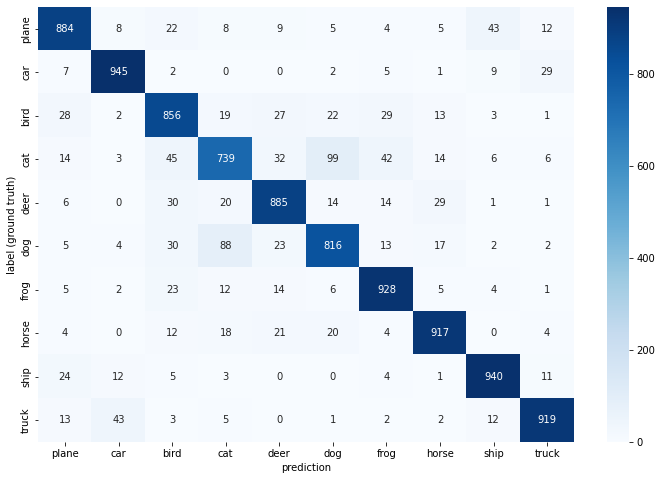

Acc of plane: 0.8840
Acc of car: 0.9450
Acc of bird: 0.8560
Acc of cat: 0.7390
Acc of deer: 0.8850
Acc of dog: 0.8160
Acc of frog: 0.9280
Acc of horse: 0.9170
Acc of ship: 0.9400
Acc of truck: 0.9190

Total Acc: 0.8829


In [21]:
hm.test(test_dataloader, load_path=PATH, class_names=class_names)

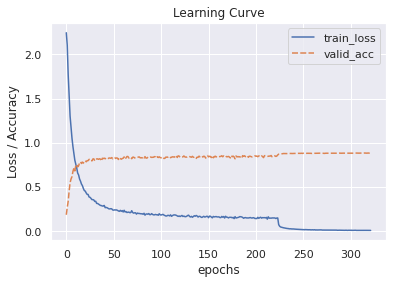

In [22]:
train_info = {"train_loss":hm.train_loss, "valid_acc":hm.valid_acc}

sns.set_theme()
fig, ax = plt.subplots(1, 1)
sns.lineplot(ax=ax, data=pd.DataFrame(train_info))
ax.set_xlabel("epochs")
ax.set_ylabel("Loss / Accuracy")
ax.set_title("Learning Curve")
plt.show()

Reference:
* [Network In Network](https://arxiv.org/pdf/1312.4400.pdf)
* [Dive into Deep Learning - Section 8.3](http://d2l.ai/chapter_convolutional-modern/nin.html)
* [Blog Post from 星期五。見面](https://meetonfriday.com/posts/a151bfa2/)
* [Blog Post from Math.py](https://allen108108.github.io/blog/2019/10/07/%5B%E8%AB%96%E6%96%87%5D%20Network%20In%20Network/)